<h1 style="text-align:center;">Handwritten Number Classification with PyTorch</h1>
<p style="text-align:center;">
M. Farhan Khan
<br>BCSF21M001
<br>Assignment 1
<br>University of The Punjab
</p>

### 1. Data Loading and Preprocessing
##### Dataset Class (`HandwrittenDataset`): -

- Loops through the directories in the dataset, collecting image paths and their labels.
- Converts floating-point labels (e.g., 0.5, 1.0) to integer indices using the `class_to_index` mapping.
- Supports data augmentation via transformations passed to the class during initialization.

##### Data Augmentation (`data_transforms`): -

- Adds transformations such as random affine transformations, resizing, and normalization to make the model robust to variations in input images.

In [6]:
import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Defining Class Labels as Floating Points according to the dataset
floating_classes = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5])

# Mapping floating point classes to integer indices
class_to_index = {float(x): int(i) for i, x in enumerate(floating_classes)}
index_to_class = {int(i): float(x) for i, x in enumerate(floating_classes)}

# Custom Dataset Class
class HandwrittenDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []  # This will store floating point labels

        # Loop through all the directories inside the root directory
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):  # Ensure it's a directory (not a file)
                for img in os.listdir(label_path):
                    self.image_paths.append(os.path.join(label_path, img))  # Add image path
                    self.labels.append(float(label))  # Convert labels to float

    def __len__(self):
        return len(self.image_paths)  # Return the number of images in the dataset

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")  # Open and convert image to RGB

        if self.transform:
            image = self.transform(image)  # Apply transformations if any

        # Convert floating point label to integer index
        label_index = class_to_index[label]  # Convert to integer label index
        return image, label_index  # Return the image and its integer label

# Data Augmentation
data_transforms = transforms.Compose([
    transforms.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=10
    ),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Loading train and test datasets
train_dataset = HandwrittenDataset(root_dir='dataset/train', transform=data_transforms)
test_dataset = HandwrittenDataset(root_dir='dataset/test', transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
]))

### 2. Data Handling
##### Stratified Splitting: -
- Splits the training dataset into training and validation subsets while maintaining the class distribution using `StratifiedShuffleSplit`.

##### Subset Creation: -

- Creates training and validation subsets from the split indices and loads them into DataLoaders.

In [7]:
# Stratified split for training and validation sets
def stratified_split(dataset, val_ratio=0.2):
    labels = np.array(dataset.labels)
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=42)
    train_idx, val_idx = next(splitter.split(np.zeros(len(labels)), labels))
    return train_idx, val_idx

# Performing stratified splitting
train_idx, val_idx = stratified_split(train_dataset)
train_set = Subset(train_dataset, train_idx)
val_set = Subset(train_dataset, val_idx)

# Creating DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### 3. Model Development
##### Custom Model Class (`CustomCNN`): -
- Initializes a pre-trained **ResNet18** model and modifies it.
- Changes the first convolutional layer to accept 3-channel inputs (RGB images).
- Updates the fully connected (FC) layer to match the number of classes (16).

##### Model Initialization: -
- Moves the model to the appropriate device (CPU/GPU).

In [8]:
# Custom CNN using ResNet-18
class CustomCNN(nn.Module):
    def __init__(self, num_classes=16):
        super(CustomCNN, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify the first convolutional layer to accept 3-channel input
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Update the fully connected layer for the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model and move it to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCNN(num_classes=16).to(device)

### 4. Training the Model
##### Weighted Loss Function: -
- Computes class weights based on the training dataset to handle class imbalance.
- Applies these weights in the `CrossEntropyLoss` function.
- Initializes the optimizer `Adam` and a learning rate scheduler `StepLR`.

##### Training Loop: -
- Trains the model for a specified number of epochs.
- Tracks and prints the training and validation loss and accuracy for each epoch.

##### Validation: -
- Evaluates the model on the validation set after each epoch and prints the validation loss and accuracy.

In [32]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=floating_classes, y=train_dataset.labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=weights)

# Define optimizer (Adam) and learning rate scheduler
optimizer = Adam(model.parameters(), lr=0.001) # Learning rate
scheduler = StepLR(optimizer, step_size=5, gamma=0.1) # Reduce LR every 5 epochs

# Create a dictionary for dataloaders
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            corrects = 0
            total = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Backward pass and optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    corrects += torch.sum(preds == labels.data)
                    total += labels.size(0)

            # Calculate loss and accuracy for the epoch
            epoch_loss = running_loss / total
            epoch_acc = (corrects.double() / total) * 100
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | {phase.capitalize()} Acc: {epoch_acc:.2f}%")
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

# Train the model
train_model(model, dataloaders, criterion, optimizer, num_epochs=15)


Epoch 1/15
----------
Train Loss: 0.4440 | Train Acc: 91.47%
Val Loss: 0.5306 | Val Acc: 90.00%
Epoch 2/15
----------
Train Loss: 0.1893 | Train Acc: 93.14%
Val Loss: 0.3337 | Val Acc: 94.67%
Epoch 3/15
----------
Train Loss: 0.1921 | Train Acc: 95.82%
Val Loss: 0.4017 | Val Acc: 88.67%
Epoch 4/15
----------
Train Loss: 0.1817 | Train Acc: 94.48%
Val Loss: 0.4238 | Val Acc: 85.33%
Epoch 5/15
----------
Train Loss: 0.5060 | Train Acc: 92.64%
Val Loss: 0.7160 | Val Acc: 80.67%
Epoch 6/15
----------
Train Loss: 0.1785 | Train Acc: 94.98%
Val Loss: 0.3320 | Val Acc: 89.33%
Epoch 7/15
----------
Train Loss: 0.1058 | Train Acc: 96.32%
Val Loss: 0.1571 | Val Acc: 93.33%
Epoch 8/15
----------
Train Loss: 0.0357 | Train Acc: 99.16%
Val Loss: 0.2930 | Val Acc: 93.33%
Epoch 9/15
----------
Train Loss: 0.1357 | Train Acc: 96.32%
Val Loss: 0.2644 | Val Acc: 95.33%
Epoch 10/15
----------
Train Loss: 0.0788 | Train Acc: 97.66%
Val Loss: 0.1349 | Val Acc: 98.00%
Epoch 11/15
----------
Train Loss: 0.04

### 5. Evaluation
##### Test Accuracy: -
- Calculates the test set accuracy by comparing predictions with true labels.

##### Classification Report: -
- Generates a detailed report showing precision, recall, F1-score, and support for each class.

##### Confusion Matrix: -
- Plots a confusion matrix to visualize the model performance.

Test Accuracy: 96.87%

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        85
           1       1.00      0.83      0.91         6
           2       0.92      0.96      0.94        25
           3       0.88      1.00      0.93         7
           4       0.98      1.00      0.99        62
           5       1.00      0.94      0.97        35
           6       1.00      1.00      1.00        54
           7       1.00      0.96      0.98        24
           8       0.98      0.99      0.99       100
           9       1.00      1.00      1.00        20
          10       0.98      0.98      0.98       322
          11       0.75      1.00      0.86        12
          12       0.89      0.99      0.94        99
          13       1.00      1.00      1.00        16
          14       0.98      0.96      0.97        49
          15       1.00      1.00      1.00        10

    accuracy                 

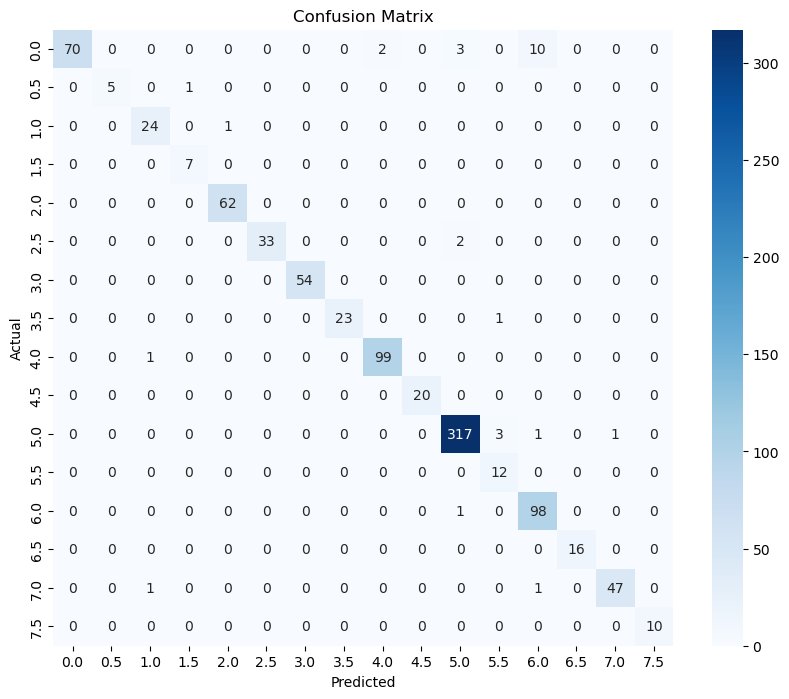

Model saved to model.pth


In [33]:
# Evaluate the model on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy in percentage
accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Metrics and confusion matrix
print("\nTest Classification Report:")
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(len(floating_classes))])
print(report)

# Generate and visualize confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=floating_classes, yticklabels=floating_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the model
torch.save(model.state_dict(), "model.pth")
print("Model saved to model.pth")

### 6. Analysis and Reflection
##### Impact of Class Imbalance: -

- Class imbalance can bias the model towards overrepresented classes.
- The weighted loss function and stratified split help mitigate this issue.
- Without weighted loss, the model may perform poorly on underrepresented classes.
- Adding class weights balances the training process.

##### Effectiveness of Data Augmentation: -

- Data augmentation techniques (e.g., random affine transformations, normalization) improve generalization by increasing dataset variability.

##### Possible Improvements: -

- Experiment with deeper architectures like ResNet50 or VGG16 for better feature extraction.
- Experiment with hyperparameters like learning rate and batch size.
- Use additional data sources or synthetic data generation to further address class imbalance.

### 7. Plots/visualizations of model performance and sample predictions
##### Training and Validation Loss: -
- Displays how the loss decreases over epochs for both training and validation, helping to monitor model convergence.

##### Training and Validation Accuracy: -
- Shows how the accuracy improves during training and validation, providing insight into model performance over time.

##### Visualization of Predictions on random test images: -
- Randomly selects test images, displaying the true labels and the predicted labels to evaluate model predictions qualitatively.

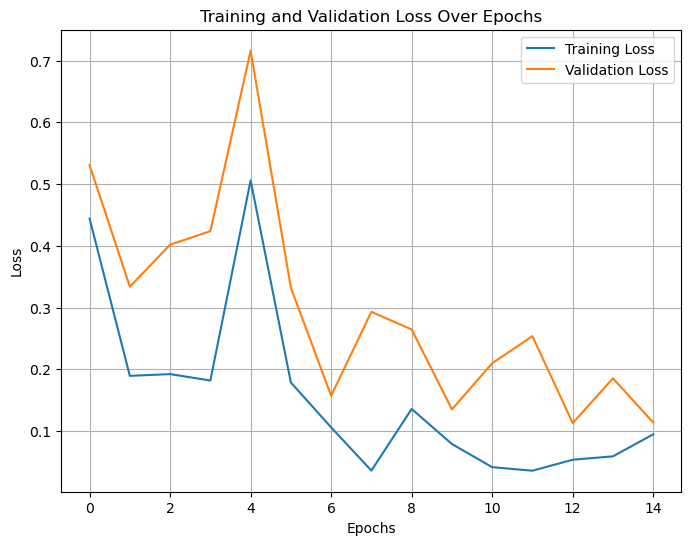

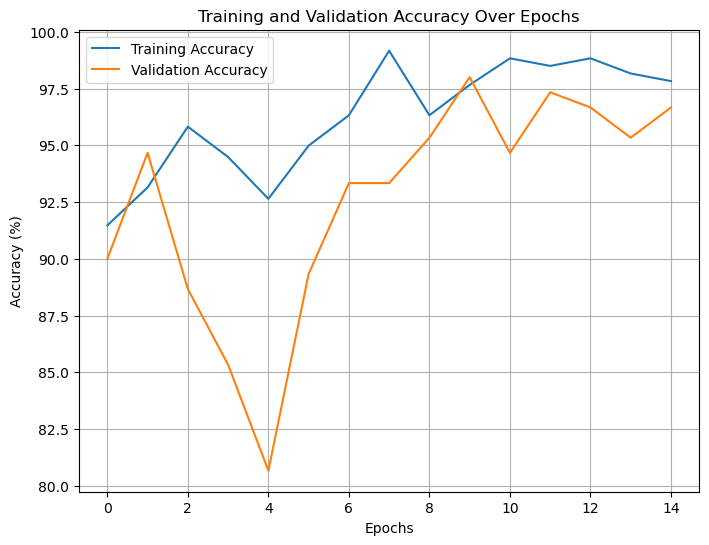

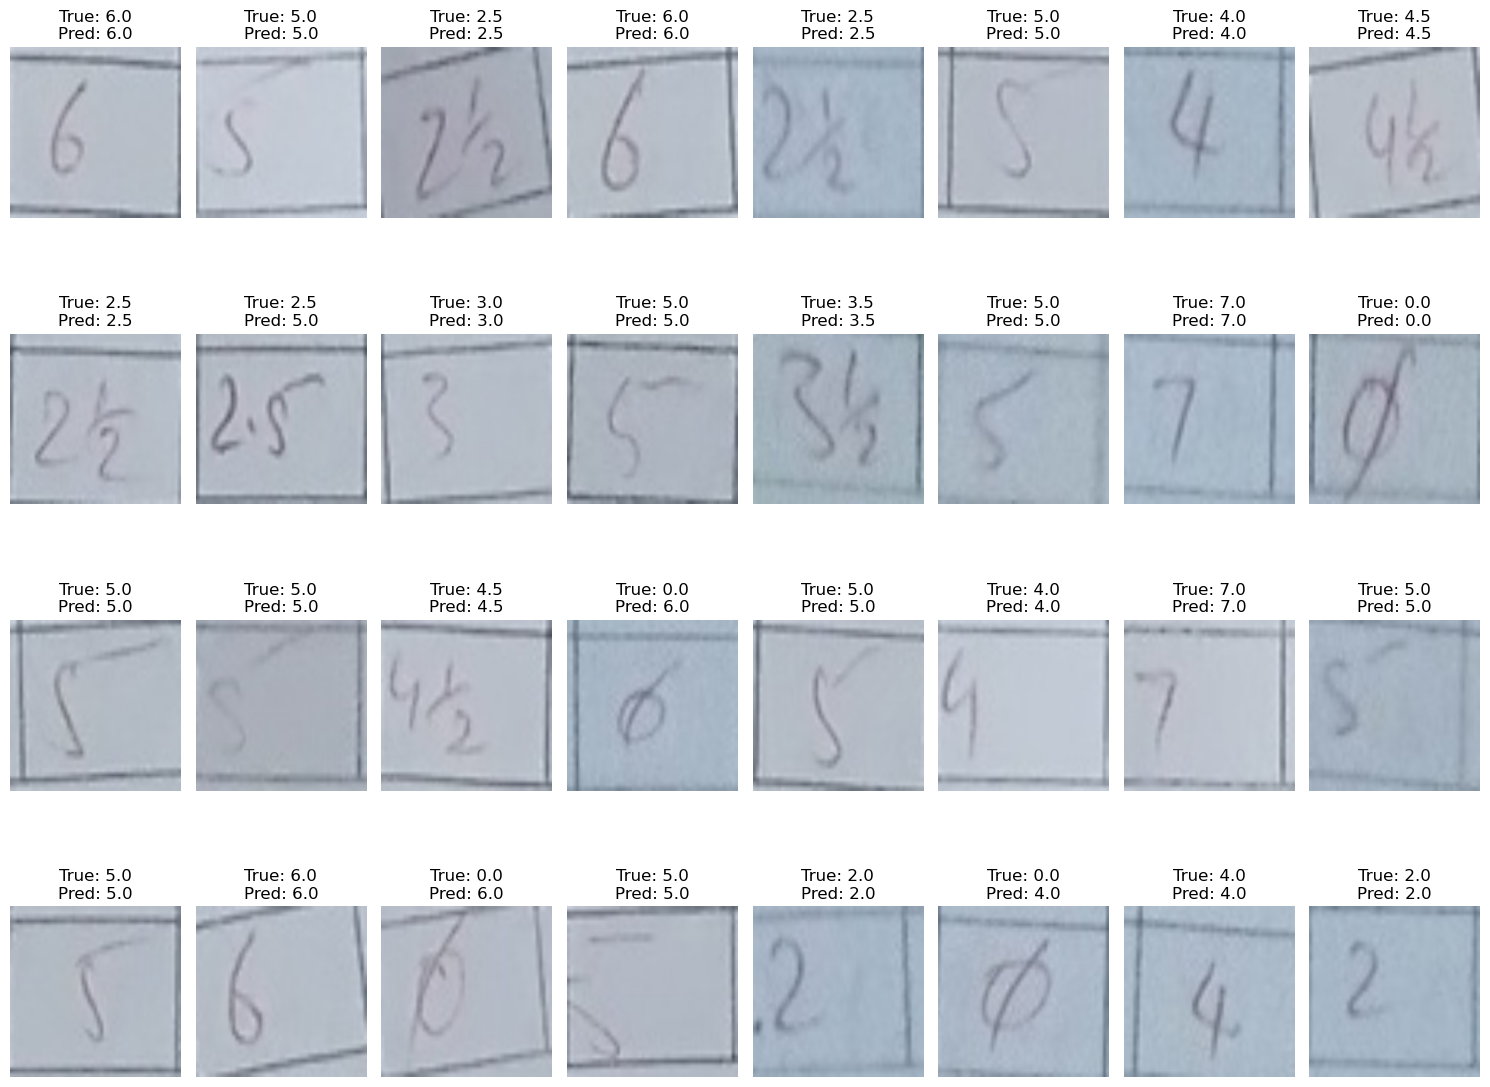

In [34]:
import math
import random

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure(figsize=(8, 6))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_random_samples(model, dataset, num_samples=10, images_per_row=8):
    model.eval()  # Set the model to evaluation mode

    # Randomly select indices from the dataset
    random_indices = random.sample(range(len(dataset)), num_samples)

    # Calculate the number of rows needed
    num_rows = math.ceil(num_samples / images_per_row)

    # Set up the figure for displaying images
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, num_rows * 3))

    # Flatten axes for easier indexing if there are multiple rows
    axes = axes.flatten()

    for i, idx in enumerate(random_indices):
        image, true_label = dataset[idx]  # Get the image and label at the random index
        image_input = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Predict the label
        with torch.no_grad():
            output = model(image_input)
            _, pred_label = torch.max(output, 1)

        # Convert image back to numpy format for display
        img = image.numpy().transpose((1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        img = img * 0.5 + 0.5  # Denormalize (mean=0.5, std=0.5)
        img = np.clip(img, 0, 1)  # Clip to [0, 1] range

        # Get true and predicted labels in floating-point format
        true_label_float = index_to_class[true_label]
        pred_label_float = index_to_class[pred_label.item()]

        # Display the image with true and predicted labels
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label_float}\nPred: {pred_label_float}")
        axes[i].axis('off')

    # Hide any unused axes (in case the total number of images is less than images_per_row * num_rows)
    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# Plot training and validation loss over epochs to evaluate the model's learning process
plot_loss(train_losses, val_losses)

# Plot training and validation accuracy over epochs to monitor performance improvements
plot_accuracy(train_accuracies, val_accuracies)

# Visualize predictions on random test images
visualize_random_samples(model, test_dataset, num_samples=32, images_per_row=8)

### 8. Bonus Tasks
##### Fine Tune: -
- Fine-tuned ResNet-18 for better task-specific feature learning.

##### Focal Loss: -
- Used to focus on hard-to-classify samples by reducing the impact of well-classified examples, improving performance on imbalanced datasets.

Epoch 1/15
----------
Train Loss: 0.9391 | Train Acc: 57.69%
Val Loss: 3.6332 | Val Acc: 46.00%
Epoch 2/15
----------
Train Loss: 0.0823 | Train Acc: 87.46%
Val Loss: 0.0397 | Val Acc: 90.67%
Epoch 3/15
----------
Train Loss: 0.0177 | Train Acc: 93.14%
Val Loss: 0.0212 | Val Acc: 94.67%
Epoch 4/15
----------
Train Loss: 0.0087 | Train Acc: 96.32%
Val Loss: 0.0487 | Val Acc: 88.00%
Epoch 5/15
----------
Train Loss: 0.0062 | Train Acc: 95.99%
Val Loss: 0.0066 | Val Acc: 96.67%
Epoch 6/15
----------
Train Loss: 0.0037 | Train Acc: 97.99%
Val Loss: 0.0041 | Val Acc: 97.33%
Epoch 7/15
----------
Train Loss: 0.0017 | Train Acc: 97.99%
Val Loss: 0.0040 | Val Acc: 96.67%
Epoch 8/15
----------
Train Loss: 0.0017 | Train Acc: 98.33%
Val Loss: 0.0037 | Val Acc: 98.00%
Epoch 9/15
----------
Train Loss: 0.0010 | Train Acc: 98.66%
Val Loss: 0.0041 | Val Acc: 96.67%
Epoch 10/15
----------
Train Loss: 0.0009 | Train Acc: 99.00%
Val Loss: 0.0017 | Val Acc: 98.00%
Epoch 11/15
----------
Train Loss: 0.00

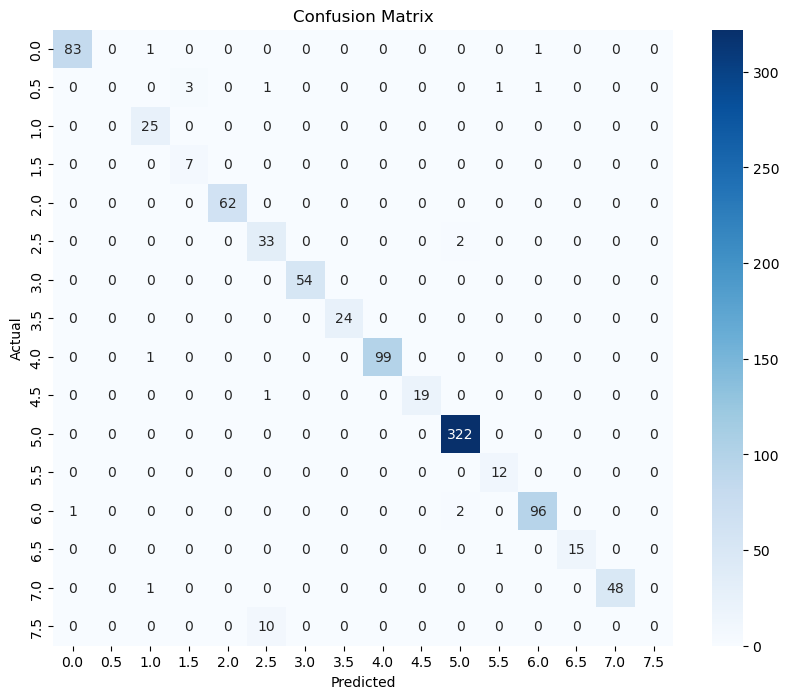

Model saved to focal_model_focal.pth


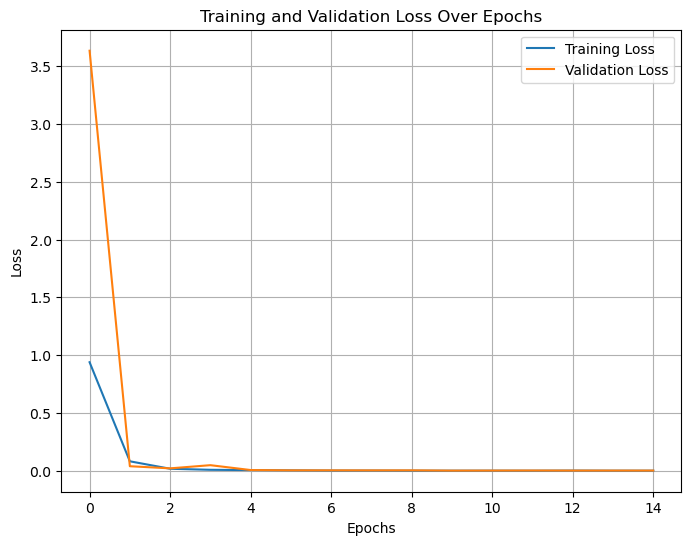

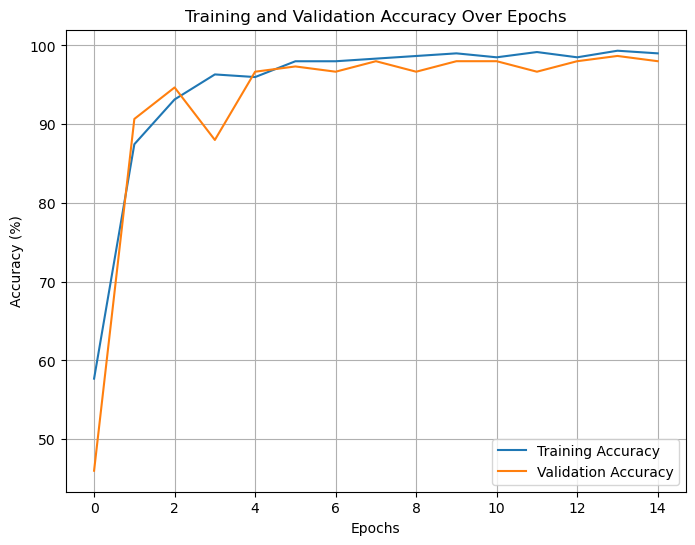

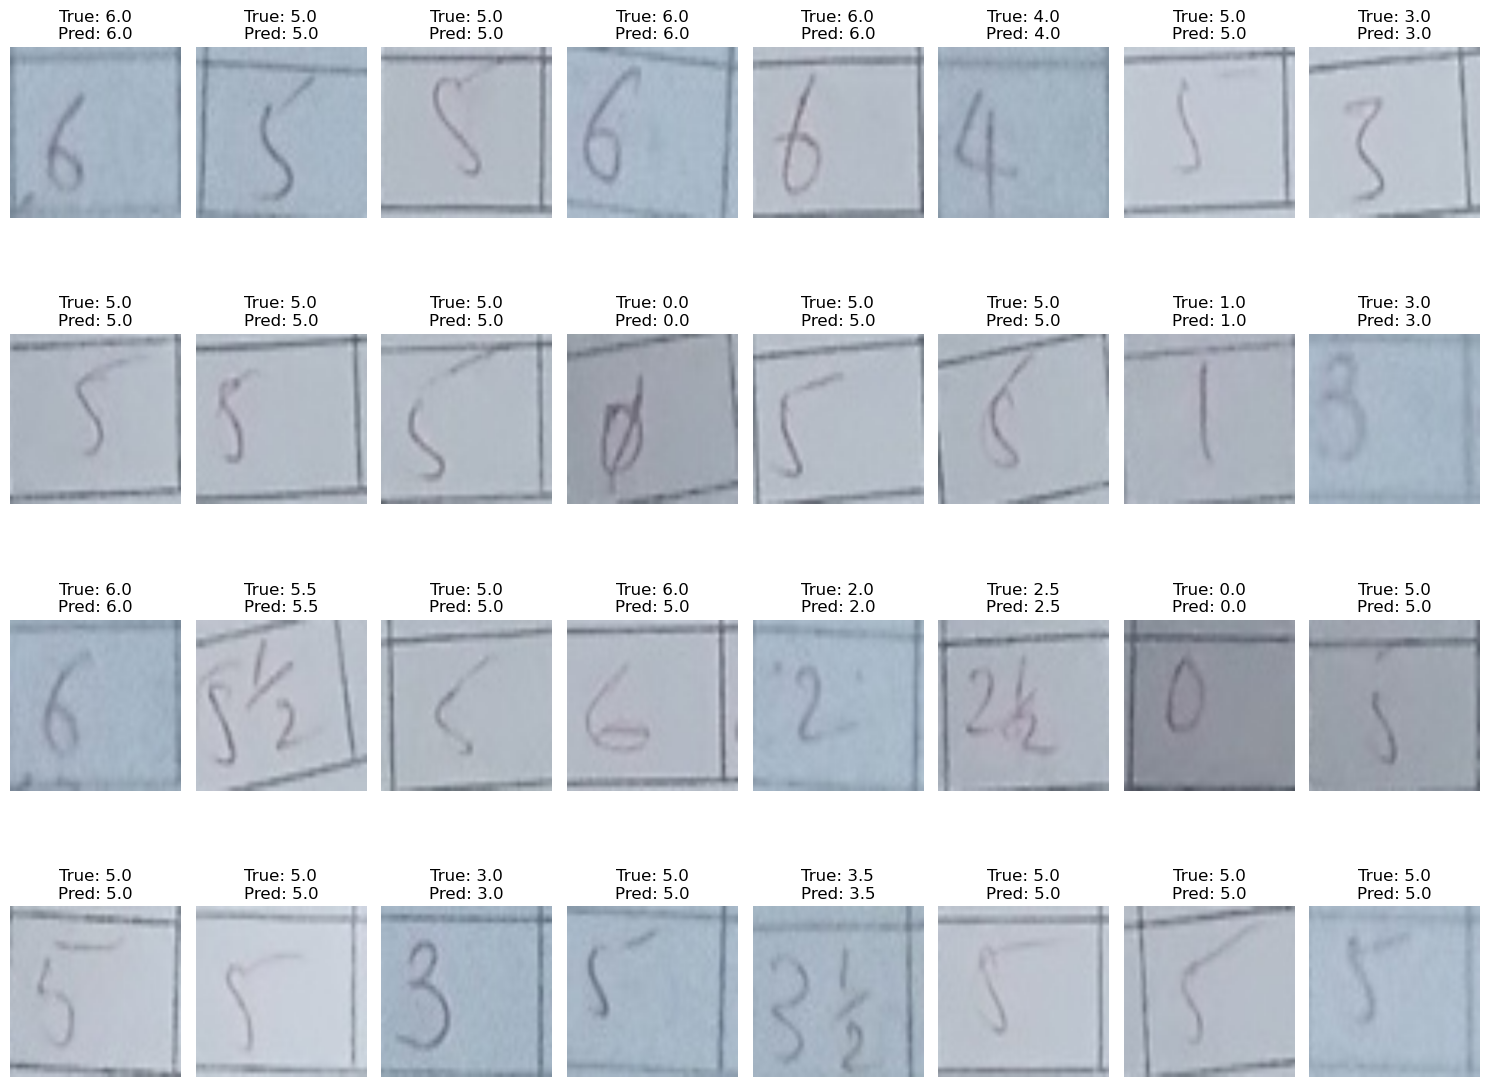

In [4]:
import os
import math
import random
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Define Focal Loss Class
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        """
        Focal Loss for handling class imbalance.

        Args:
        - alpha (float): Scaling factor for positive samples.
        - gamma (float): Focusing parameter to down-weight easy examples.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)  # Standard CrossEntropyLoss
        pt = torch.exp(-ce_loss)  # Probability of the true class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss  # Focal loss formula
        return focal_loss

# Floating point class labels
floating_classes = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5])

# Mapping floating point classes to integer indices
class_to_index = {float(x): int(i) for i, x in enumerate(floating_classes)}
index_to_class = {int(i): float(x) for i, x in enumerate(floating_classes)}

# Custom Dataset Class
class HandwrittenDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []  # This will store floating point labels

        # Loop through all the directories inside the root directory
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):  # Ensure it's a directory (not a file)
                for img in os.listdir(label_path):
                    self.image_paths.append(os.path.join(label_path, img))  # Add image path
                    self.labels.append(float(label))  # Convert labels to float

    def __len__(self):
        return len(self.image_paths)  # Return the number of images in the dataset

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")  # Open and convert image to RGB

        if self.transform:
            image = self.transform(image)  # Apply transformations if any

        # Convert floating point label to integer index
        label_index = class_to_index[label]  # Convert to integer label index
        return image, label_index  # Return the image and its integer label

# Data Augmentation
data_transforms = transforms.Compose([
    transforms.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=10
    ),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
train_dataset = HandwrittenDataset(root_dir='dataset/train', transform=data_transforms)
test_dataset = HandwrittenDataset(root_dir='dataset/test', transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
]))

# Stratified split for training and validation sets
def stratified_split(dataset, val_ratio=0.2):
    labels = np.array(dataset.labels)
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=42)
    train_idx, val_idx = next(splitter.split(np.zeros(len(labels)), labels))
    return train_idx, val_idx

# Performing stratified splitting
train_idx, val_idx = stratified_split(train_dataset)
train_set = Subset(train_dataset, train_idx)
val_set = Subset(train_dataset, val_idx)

# Creating DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Custom CNN using ResNet-18
class CustomCNN(nn.Module):
    def __init__(self, num_classes=16):
        super(CustomCNN, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify the first convolutional layer to accept 3-channel input
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Update the fully connected layer for the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model and move it to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCNN(num_classes=16).to(device)

# Use Focal Loss instead of CrossEntropyLoss
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Create a dictionary for dataloaders
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            corrects = 0
            total = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                corrects += torch.sum(preds == labels.data)
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = (corrects.double() / total) * 100

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | {phase.capitalize()} Acc: {epoch_acc:.2f}%")

        scheduler.step()  # Adjust learning rate

# Train the model
train_model(model, dataloaders, criterion, optimizer, num_epochs=15)

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy in percentage
accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Metrics and confusion matrix
print("\nTest Classification Report:")
report = classification_report(all_labels, all_preds, target_names=[str(cls) for cls in floating_classes], zero_division=1)
print(report)

# Generate and visualize confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=floating_classes, yticklabels=floating_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the model
torch.save(model.state_dict(), "focal_model_focal.pth")
print("Model saved to focal_model_focal.pth")

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure(figsize=(8, 6))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_random_samples(model, dataset, num_samples=10, images_per_row=8):
    model.eval()  # Set the model to evaluation mode

    # Randomly select indices from the dataset
    random_indices = random.sample(range(len(dataset)), num_samples)

    # Calculate the number of rows needed
    num_rows = math.ceil(num_samples / images_per_row)

    # Set up the figure for displaying images
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, num_rows * 3))

    # Flatten axes for easier indexing if there are multiple rows
    axes = axes.flatten()

    for i, idx in enumerate(random_indices):
        image, true_label = dataset[idx]  # Get the image and label at the random index
        image_input = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Predict the label
        with torch.no_grad():
            output = model(image_input)
            _, pred_label = torch.max(output, 1)

        # Convert image back to numpy format for display
        img = image.numpy().transpose((1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        img = img * 0.5 + 0.5  # Denormalize (mean=0.5, std=0.5)
        img = np.clip(img, 0, 1)  # Clip to [0, 1] range

        # Get true and predicted labels in floating-point format
        true_label_float = index_to_class[true_label]
        pred_label_float = index_to_class[pred_label.item()]

        # Display the image with true and predicted labels
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label_float}\nPred: {pred_label_float}")
        axes[i].axis('off')

    # Hide any unused axes (in case the total number of images is less than images_per_row * num_rows)
    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# Plot training and validation loss over epochs to evaluate the model's learning process
plot_loss(train_losses, val_losses)

# Plot training and validation accuracy over epochs to monitor performance improvements
plot_accuracy(train_accuracies, val_accuracies)

# Visualize predictions on random test images
visualize_random_samples(model, test_dataset, num_samples=32, images_per_row=8)